In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import periodogram, welch
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20,10]

In [3]:
data = pd.read_csv('FluNetInteractiveReport.csv')
data_nas = data.describe()

In [4]:
data['SDATE'] = pd.to_datetime(data['SDATE'])
data['EDATE'] = pd.to_datetime(data['EDATE'])

In [5]:
categoricals = data.columns[data.dtypes == 'object']
categoricals

Index(['Country', 'WHOREGION', 'FLUREGION', 'TITLE'], dtype='object')

In [6]:
for x in categoricals:
    data[x] = data[x].astype('category')

In [7]:
data.set_index(['EDATE'], inplace=True)

In [8]:
numerics = data.columns[data.dtypes == 'float']

In [9]:
data = data[data.Country != 'Bermuda']
data = data[data.index.year.isin([2017, 2018, 2019, 2020])]

![Data Dictionary](datadefinitions.jpeg)

SPEC_RECEIVED_NB
SPEC_PROCESSED_NB
AH1
AH1N12009
AH3
AH5
ANOTSUBTYPED
INF_A
BYAMAGATA
BVICTORIA
BNOTDETERMINED
INF_B
ALL_INF
ALL_INF2


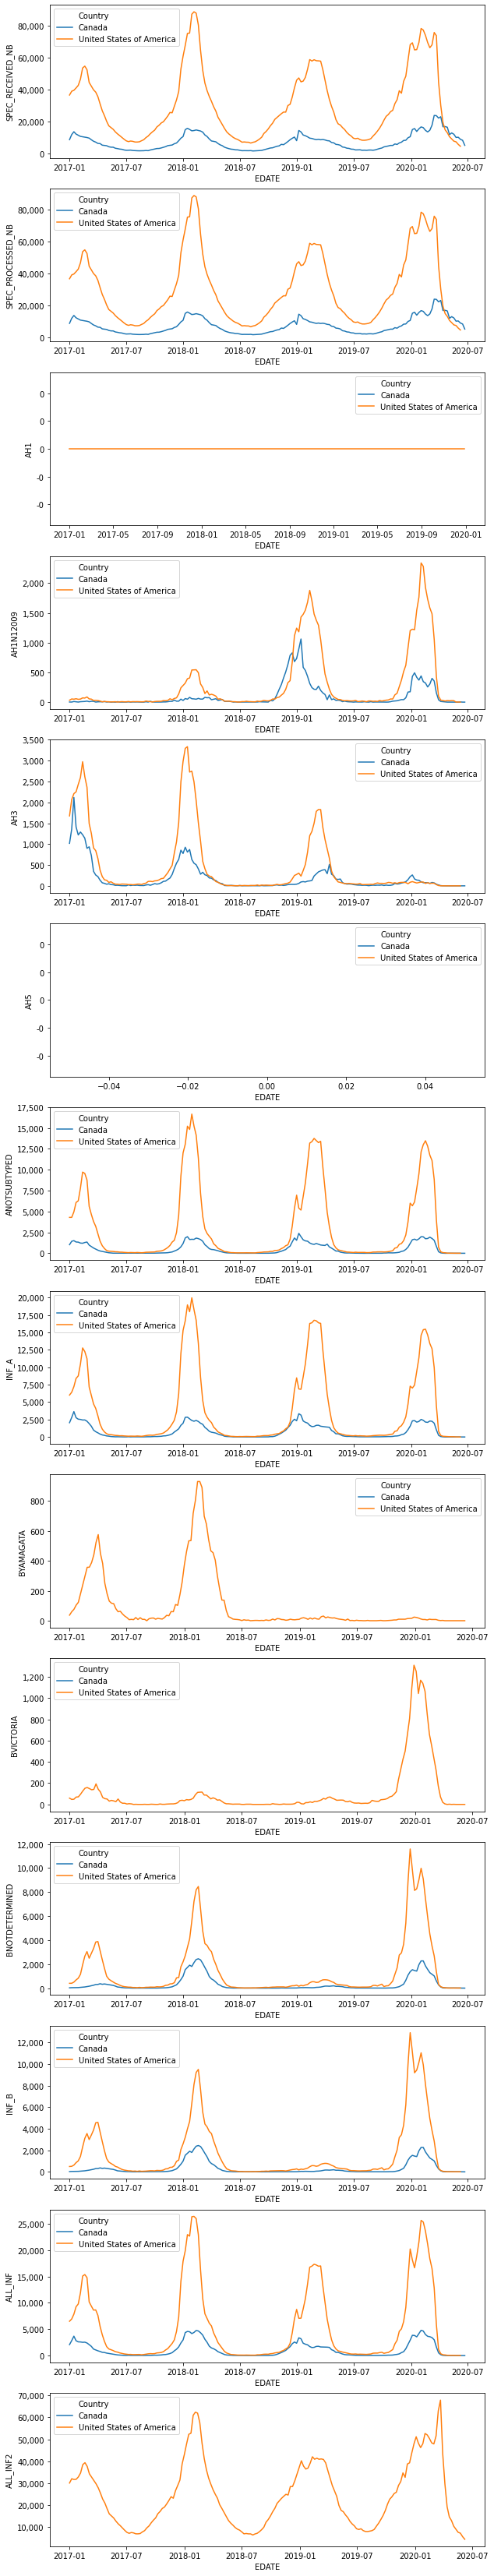

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=len(numerics), figsize=(10, 60))
ax.ravel()
for i, col in enumerate(numerics):
    print(col)
    p = sns.lineplot(x=data.index, y=data[col], hue=data['Country'], ax=ax[i])
    p.set_yticklabels([f'{y:,.0f}' for y in p.get_yticks()])

SPEC_RECEIVED_NB
SPEC_PROCESSED_NB
AH1
AH1N12009
AH3
AH5
ANOTSUBTYPED
INF_A
BYAMAGATA
BVICTORIA
BNOTDETERMINED
INF_B
ALL_INF
ALL_INF2


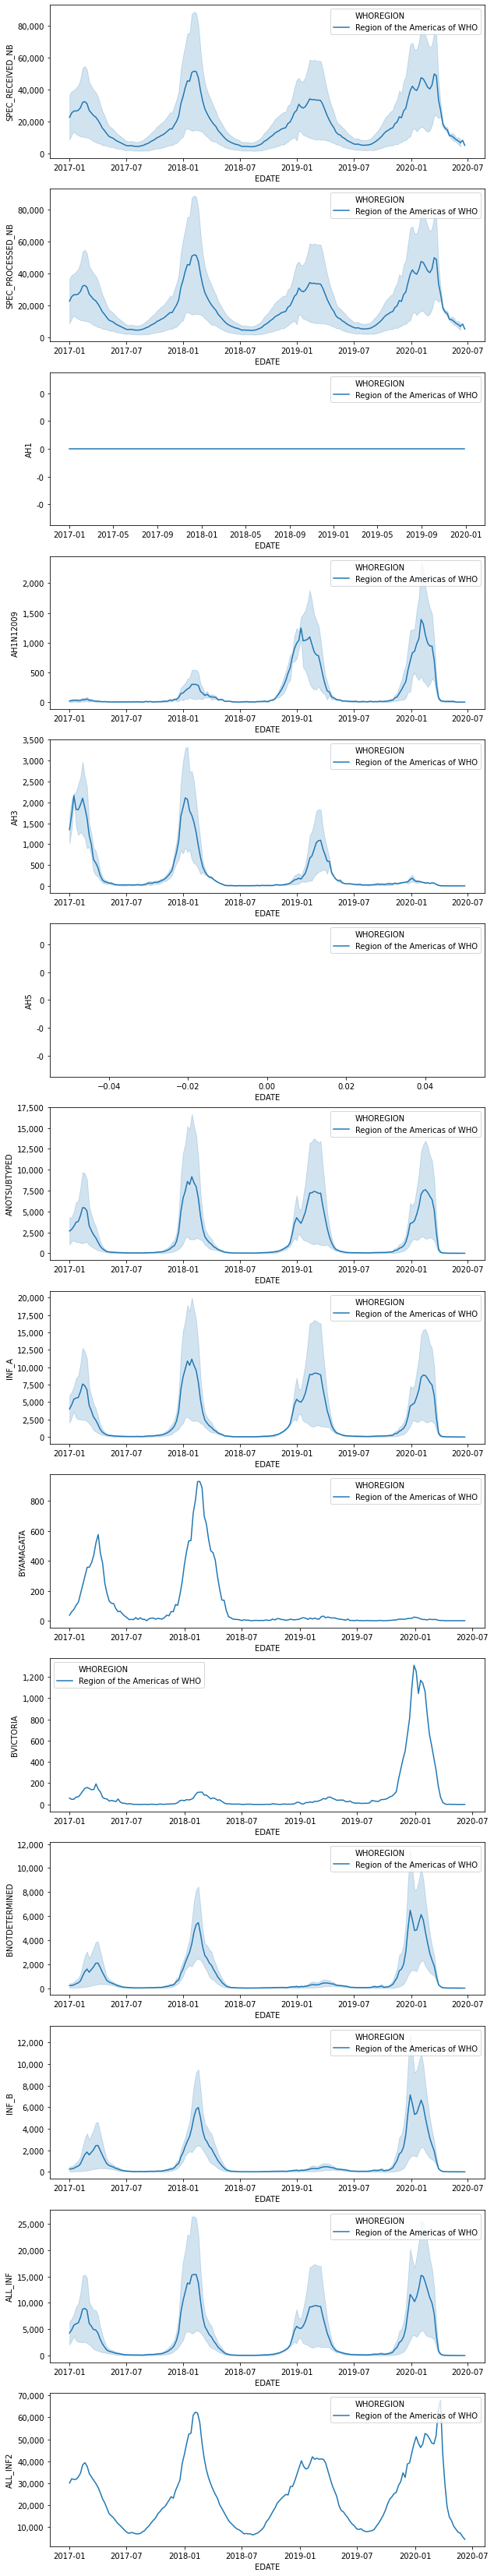

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=len(numerics), figsize=(10, 60))
ax.ravel()
for i, col in enumerate(numerics):
    print(col)
    p = sns.lineplot(x=data.index, y=data[col], hue=data['WHOREGION'], ax=ax[i])
    p.set_yticklabels([f'{y:,.0f}' for y in p.get_yticks()])

## [Exploring Statsmodels Time Series Analysis]('https://www.statsmodels.org/stable/tsa.html')

- Let's explore the autocorrelation (**ACF**) and partial autocorrelation (**PACF**) structures of each our independent variables. 

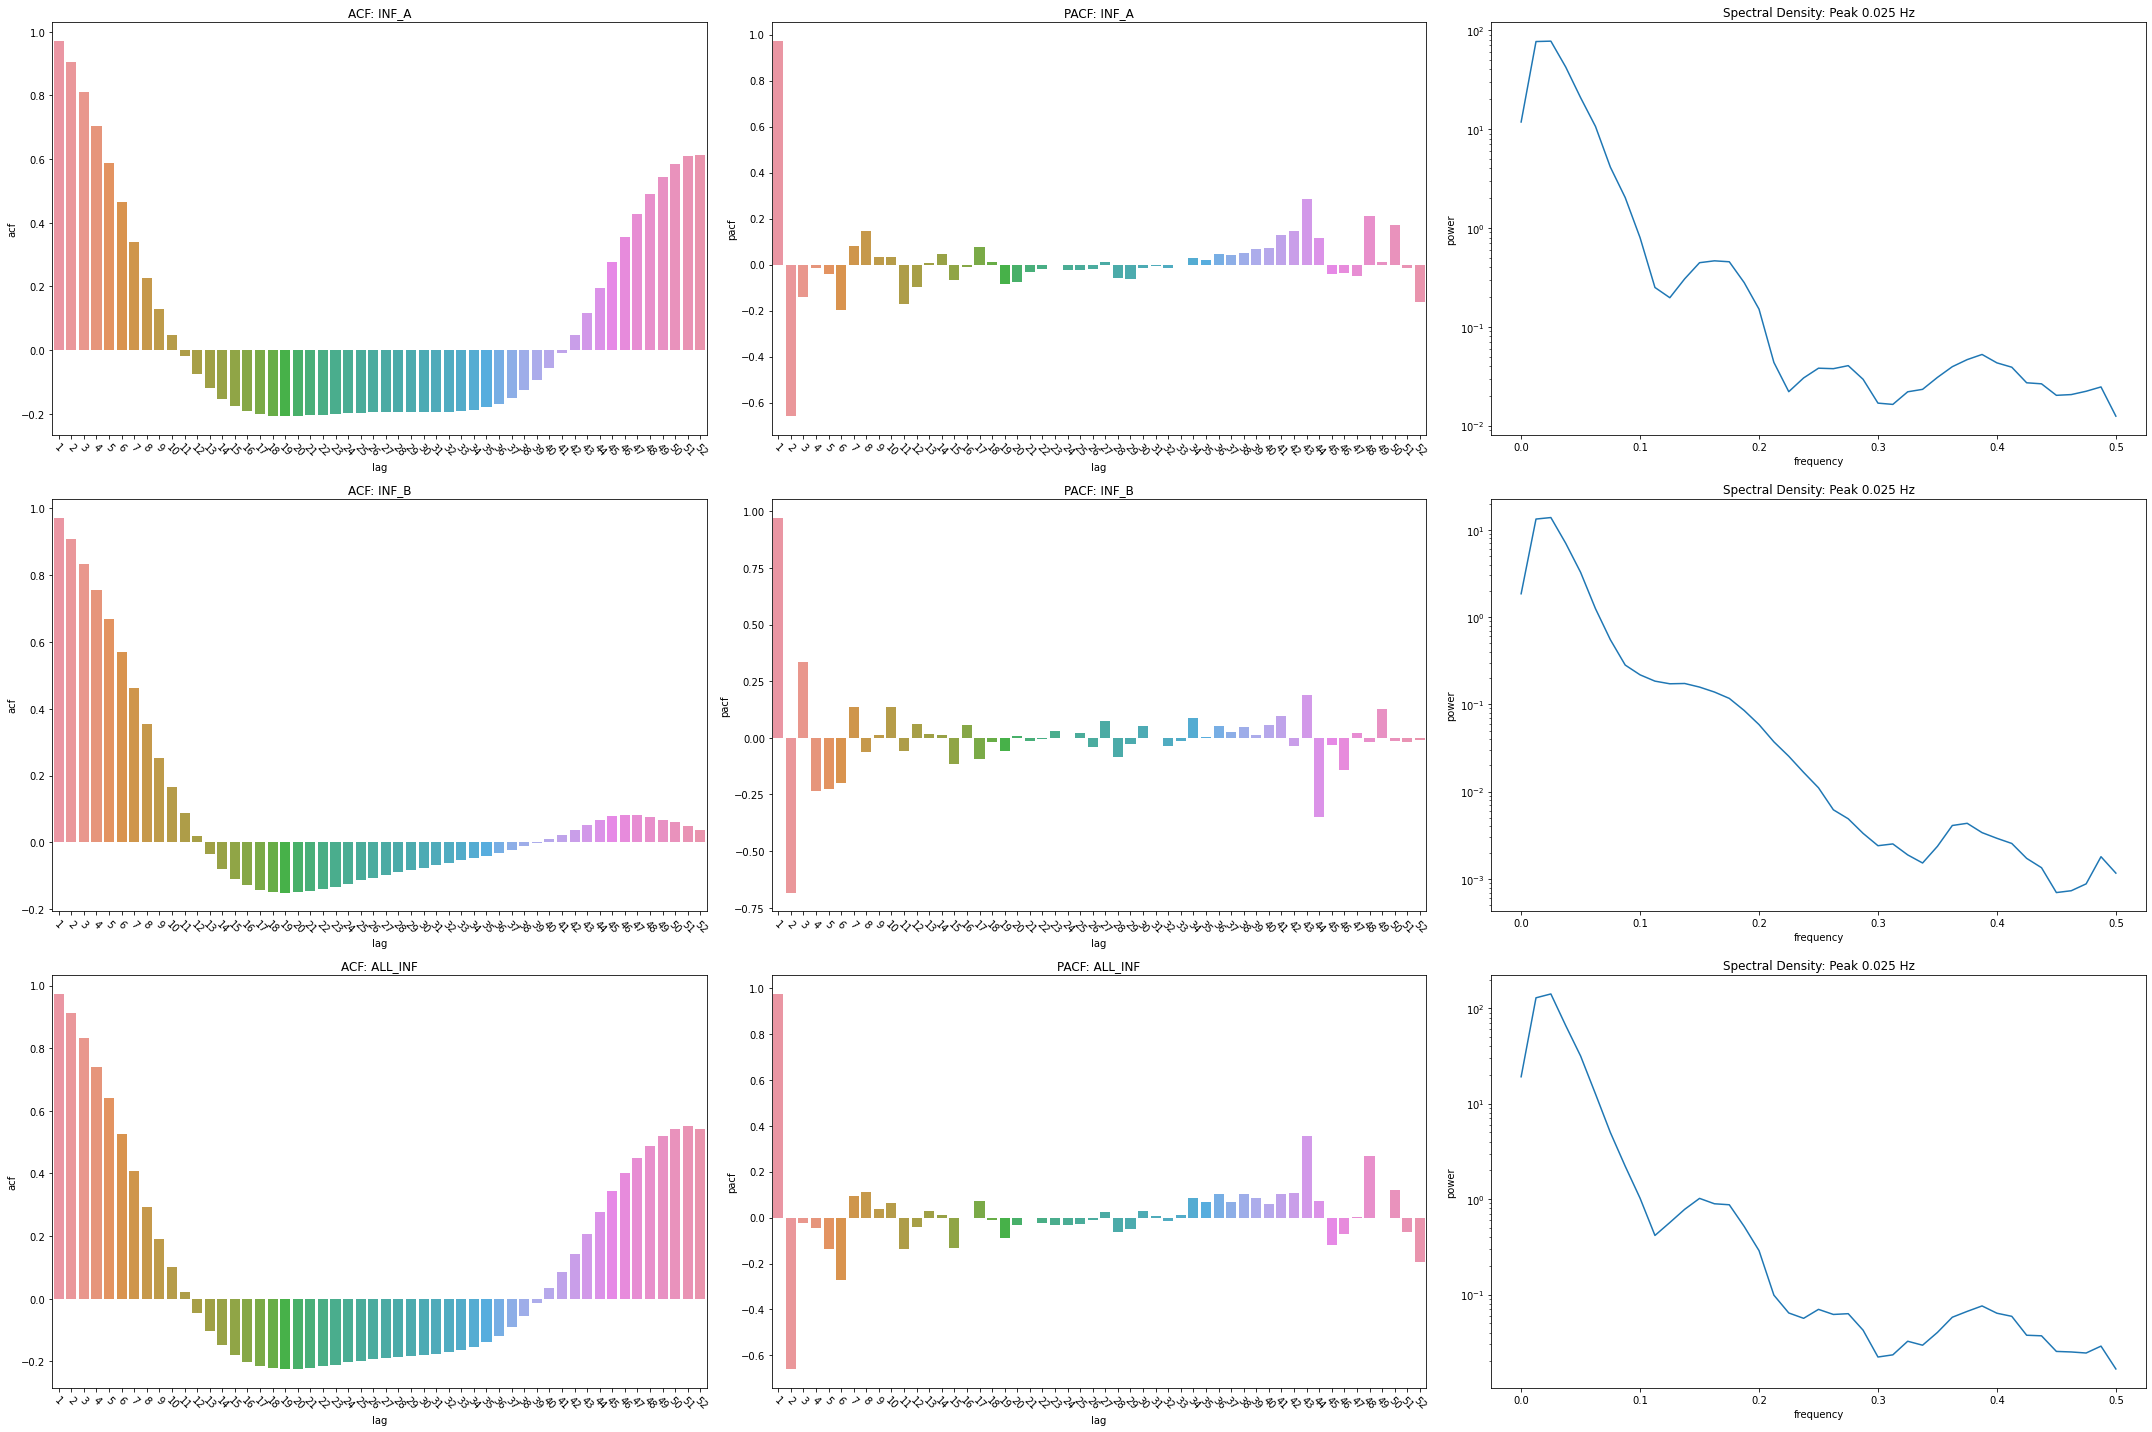

In [23]:

display_cols = ['INF_A', 'INF_B', 'ALL_INF']
fig, ax = plt.subplots(ncols=3, nrows=len(display_cols), figsize=(30,20))
ax.ravel()
for i, x in enumerate(display_cols):
    acf = sm.tsa.acf(data[x].dropna(), nlags=52, fft=False)
    pacf = sm.tsa.pacf_ols(data[x].dropna(), nlags=52)
    acf = sns.barplot(data=pd.DataFrame({'lag':range(1, len(acf)),
                          'acf':acf[1:]}), x='lag', y='acf', ax=ax[i, 0])
    pacf = sns.barplot(data=pd.DataFrame({'lag':range(1, len(pacf)),
                          'pacf':pacf[1:]}), x='lag', y='pacf', ax=ax[i, 1])
    period_gram = welch(data[x].dropna(), scaling='spectrum', nperseg=80)
    max_freq = period_gram[0][period_gram[1].argmax()]
    period_gram = sns.lineplot(data=pd.DataFrame({'frequency':period_gram[0],
                          'power':period_gram[1]/(1e5)}), x='frequency', y='power', ax=ax[i, 2])
    acf.set_title(f'ACF: {x}')
    pacf.set_title(f'PACF: {x}')
    period_gram.set_title(f'Spectral Density: Peak {round(max_freq, 3)} Hz')
    pacf.set_xticklabels(pacf.get_xticklabels(),rotation=-45)
    acf.set_xticklabels(acf.get_xticklabels(),rotation=-45)
    period_gram.set_yscale('log')
    
#fig.tight_layout(h_pad=1.1)
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()

### Model Building 

- Overfit to start

In [24]:
model_a = sm.tsa.arma_order_select_ic(y=data[data.Country == 'United States of America']['INF_A'].dropna())

In [25]:
model_b = sm.tsa.arma_order_select_ic(y=data[data.Country == 'United States of America']['INF_B'].dropna())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


In [26]:
model_all = sm.tsa.arma_order_select_ic(y=data[data.Country == 'United States of America']['ALL_INF'].dropna())

In [27]:
model_a

{'bic':              0            1            2
 0  3618.631910  3398.955210  3263.609441
 1  3119.237832  3041.751166  3008.560670
 2  2987.983789  2992.152359  2997.315653
 3  2992.104174  2986.536237  3002.093618
 4  2997.183575  3002.274955  2995.555618,
 'bic_min_order': (3, 1)}

In [28]:
model_b

{'bic':              0            1            2
 0  3366.529239  3141.931906  2973.565145
 1  2868.161297  2755.762887  2742.023594
 2  2760.211983  2736.990365  2741.933658
 3  2743.083539  2741.885361  2739.728066
 4  2736.516420  2730.886291  2732.952661,
 'bic_min_order': (4, 1)}

In [29]:
model_all

{'bic':              0            1            2
 0  3723.177125  3499.286197  3363.201816
 1  3214.984392  3132.134581  3111.028326
 2  3095.900688  3100.756418  3103.451748
 3  3100.794907  3103.252745  3098.179619
 4  3105.563741  3096.992775  3102.318737,
 'bic_min_order': (2, 0)}

### Todo: agg by month, only look at months where FluSeason = 1

### Simulating Data

Simulating an ARMA process for given values of $\theta\ and\ \phi$

$$y_{t}=\phi_{1}y_{t-1}+\ldots+\phi_{p}y_{t-p}+\theta_{1}\epsilon_{t-1}
           +\ldots+\theta_{q}\epsilon_{t-q}+\epsilon_{t}$$
           
$$ Where\ the\ \phi\ are\ the\ AR\ Frequencies\$$

$$ Where\ the\ \theta\ are\ the\ MA\ Frequencies\$$

***ArmaProcess***

In [31]:
#ArmaProcess? ## used to generate sample AR/MA processed 
## args parameters must be negative
ar = np.array([0.57, -0.25])
ma = np.array([0.65, 0.35])
ar = np.r_[1, -ar] # must add a zero lag term, 1 and negate the AR components 
ma = np.r_[1, ma]
x = sm.tsa.ArmaProcess(ar, ma)
print(x.isstationary) #AR roots are all outside the unit circle
print(x.isinvertible)

True
True


### True Autocorrelations


**ACF**

In [36]:
acf = ts.arima_process.arma_acf(ar=np.array([1, .5]), ma=np.array([1, .3]), lags=20)

In [37]:
pacf = ts.arima_process.arma_pacf(ar=np.array([1, .5]), ma=np.array([1, .3]), lags=20)

In [ ]:
def show_acf(acf, title, ax):
    return sns.barplot(data=acf, y='acf', x='lag', ax=ax, title=title)

def show_pacf(pacf, title, ax):
    return sns.barplot(data=pd.DataFrame({'lag':range(1, len(pacf)),
                          'pacf':pacf[1:]}), y='pacf', x='lag', ax=ax)#, title=title)


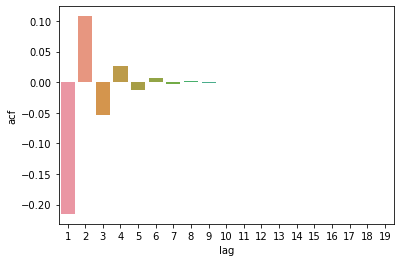

In [38]:
sns.barplot(data=pd.DataFrame({'lag':range(1, len(acf)),
                          'acf':acf[1:]}), y='acf', x='lag')

#### Assumptions

- Is data stationary or non

- Run lag diff analysis

- Data is weekly, we should expect to see seasonality at n=52

In [ ]:
ts.stattools.arma_order_select_ic?
